# Getting started with Qiskit and IonQ on Azure Quantum

This notebook shows how to send a basic quantum circuit expressed using the [Qiskit library](https://github.com/QISKit/qiskit-terra) to an IonQ target via the Azure Quantum service.

First, install `azure-quantum` with the `qiskit` dependencies, and `matplotlib` for plotting:

In [1]:
# To install the Azure Quantum client package with support for
# Qiskit, uncomment and run the line below:
#
# !pip install azure-quantum[qiskit]==0.19.2109.165653 --quiet
#
# We also recommend installing matplotlib, if you don't have it installed already:
# !pip install matplotlib --quiet

And import the required packages for this sample:

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

## Connecting to the Azure Quantum service

To connect to the Azure Quantum service, find the resource ID and location of your Workspace from the Azure portal here: https://portal.azure.com. Navigate to your Azure Quantum workspace and copy the values from the header.

<img src="../azure-quantum-resource-id.png" alt="How to retrieve the resource ID and location from an Azure Quantum workspace">

Paste the values into the following `AzureQuantumProvider` constructor to create a `provider` object that connects to your Azure Quantum workspace.

In [3]:
provider = AzureQuantumProvider(
  resource_id="",
  location=""
)

Use `provider.backends` to see what targets are currently available. Running this method will trigger authentication to your Microsoft account, if you're not already logged in.

In [4]:
print([backend.name() for backend in provider.backends()])

['ionq.qpu', 'ionq.simulator', 'quantinuum.qpu.h1-1', 'quantinuum.sim.h1-1sc', 'quantinuum.qpu.h1-2', 'quantinuum.sim.h1-2sc', 'quantinuum.sim.h1-1e']


## Run a simple circuit

Let's create a simple Qiskit circuit to run.

This notebook assumes some familiarity with Qiskit. To read more about Qiskit, review the [Qiskit documentation](https://qiskit.org/documentation/intro_tutorial1.html).

In [5]:
# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(3, 3)
circuit.name = "Qiskit Sample - 3-qubit GHZ circuit"
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure([0,1,2], [0, 1, 2])

# Print out the circuit
circuit.draw()

┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2

To get a result back quickly, use `provider.get_backend` to create a `Backend` object to connect to the IonQ Simulator back-end:

In [6]:
simulator_backend = provider.get_backend("ionq.simulator")

You can now run the program via the Azure Quantum service and get the result. The following cell will submit a job that runs the circuit with 100 shots:

In [7]:
job = simulator_backend.run(circuit, shots=100)
job_id = job.id()
print("Job id", job_id)

Job id 6255e7ce-1ca0-11ec-9d4c-00155dd132ce


To monitor job progress, we can use the Qiskit `job_monitor` we imported earlier to keep track of the Job's status. Note that this call will block until the job completes:

In [8]:
job_monitor(job)

Job Status: job has successfully run


To wait until the job is completed and return the results, run:

In [9]:
result = job.result()

This returns a `qiskit.Result` object.

In [10]:
type(result)

qiskit.result.result.Result

In [11]:
print(result)

Result(backend_name='ionq.simulator', backend_version='1', qobj_id='Qiskit Sample - 3-qubit GHZ circuit', job_id='6255e7ce-1ca0-11ec-9d4c-00155dd132ce', success=True, results=[ExperimentResult(shots=100, success=True, meas_level=2, data=ExperimentResultData(counts={'000': 50, '111': 50}, probabilities={'000': 0.5, '111': 0.5}), header=QobjExperimentHeader(meas_map='[0, 1, 2]', name='Qiskit Sample - 3-qubit GHZ circuit', num_qubits='3', qiskit='True'))])


Because this is an object native to the Qiskit package, we can use Qiskit's `result.get_counts` and `plot_histogram` to visualize the results. The results can return a sparse dictionary so to make sure all possible bitstring lables are represented we add them to `counts`.

{'000': 50, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 50}


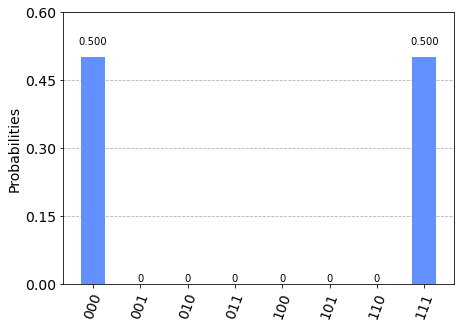

In [12]:
# The histogram returned by the results can be sparse, so here we add any of the missing bitstring labels.
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts);

### Run on IonQ QPU

To connect to real hardware (Quantum Processing Unit or QPU), simply provide the name of the target `"ionq.qpu"` to the `provider.get_backend` method:

In [13]:
qpu_backend = provider.get_backend("ionq.qpu")

Submit the circuit to run on Azure Quantum. Note that depending on queue times this may take a while to run!

Here we will again use the `job_monitor` to keep track of the job status, and `plot_histogram` to plot the results.

Job id 614da722-fa72-11eb-9e14-00155df1914a
Job Status: job has successfully run
Result(backend_name='ionq.simulator', backend_version='1', qobj_id='Qiskit Sample - 3-qubit GHZ circuit', job_id='614da722-fa72-11eb-9e14-00155df1914a', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0': 505, '1': 6, '2': 1, '3': 1, '4': 1, '5': 10, '6': 11, '7': 488}, probabilities={'0': 0.4932, '1': 0.0059, '2': 0.001, '3': 0.001, '4': 0.001, '5': 0.0098, '6': 0.0117, '7': 0.4766}), header=QobjExperimentHeader(name='Qiskit Sample - 3-qubit GHZ circuit', num_qubits='3', qiskit='True'))])
{'000': 505, '001': 6, '010': 1, '011': 1, '100': 1, '101': 10, '110': 11, '111': 488}


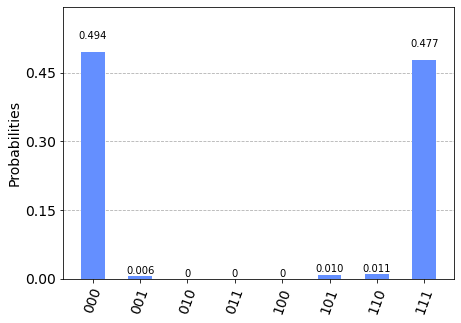

In [8]:
# Submit the circuit to run on Azure Quantum
qpu_job = qpu_backend.run(circuit, shots=1024)
job_id = qpu_job.id()
print("Job id", job_id)

# Monitor job progress and wait until complete:
job_monitor(qpu_job)

# Get the job results (this method also waits for the Job to complete):
result = qpu_job.result()
print(result)
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts)

In [9]:
# Print package versions used in this notebook
import qiskit
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

qiskit==0.18.0
